# **Rent Prediction(Introduction)**

### Introduction

Here in this project, I'm trying to build a Machine Learning model which will predict the rent amount for houses based on a dataset from Kaggle.

### Data

1.   Source: https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent/
2.   Description: This dataset contains various information(13 columns) about 10,692 houses in Brazil.



### Approach & Goal

First I'll be doing some basic Data Exploration to know more about my dataset. Then based on my EDA(Exploratory Data Exploration), I'll be doing some Data Cleaning so that I can build my Regression Model on it. Then I will build a baseline model to predict the rent amount which I will then try to optimize and finally pick the model which performed the best i.e. which had the highest R^2 Score.

# **Uploading Dataset**

Here I'm just uploading the dataset from my system to google colab.

In [ ]:
from google.colab import files
uploaded=files.upload()
import pandas as pd 
import io
rent=pd.read_csv(io.BytesIO(uploaded['houses_to_rent_v2.csv']))

Saving houses_to_rent_v2.csv to houses_to_rent_v2.csv


# **Data Exploration(1)**

In [ ]:
rent.head() # to check what all columns we have about the houses

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [ ]:
rent.dtypes # to check data types of all the columns

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

The above code snippet helps us to identify the object type columns as we will need to convert them to numerical type to build our model later on.

In [ ]:
rent.isnull().sum() # to check if there are any null values anywhere in our dataset

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

As we can see from above, there are no NULL values in our dataset.

Now one by one we'll first explore all the object type columns and see how we can convert them to numerical type.

Now we'll explore the city column and find out the number of cities there are in our dataset.

In [ ]:
rent.city.unique()

array(['São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas',
       'Belo Horizonte'], dtype=object)

Now we'll explore the floor column and find out the number of floor types there are in our data. As there are multiple types of cities here, we'll be doing One Hot Encoding here.

In [ ]:
rent.floor.unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

As we can see, this column is of object type because there is a '-' value in the column, so we need to replace it with some other numerical value accordingly.

In [ ]:
rent.animal.unique()

array(['acept', 'not acept'], dtype=object)

As we can see, there are only 2 types here, so we'll be converting them to 1(acept)and 0(not acept). This is known as Label Encoding.

In [ ]:
rent.furniture.unique()

array(['furnished', 'not furnished'], dtype=object)

As we can see, there are only 2 types here, so we'll be converting them to 1(furnished)and 0(not furnished).

# **Data Cleaning**

Function to convert furniture column to numerical type

In [ ]:
def furniture(x):
    if x=='furnished':
        return 1
    else:
        return 0

Function to convert animal column to numerical type

In [ ]:
def animal(x):
    if x=='acept':
        return 1
    else:
        return 0

In [ ]:
rent['furniture']=rent['furniture'].apply(furniture) #applied our function to convert data type from object to numerical
rent['animal']=rent['animal'].apply(animal)          #applied our function to convert data type from object to numerical

In [ ]:
rent[rent.floor=='-'].describe() # to check how many datapoints have their floor value as '-'

,area,rooms,bathroom,parking spaces,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000,2461.000000
mean,231.622105,3.054043,2.826493,2.428281,0.809833,0.143844,134.710687,4946.346201,440.172288,76.196262,5597.558716
std,189.582151,1.422498,1.697070,2.231937,0.392512,0.351003,698.342176,4013.794195,839.181049,61.980466,4716.551149
min,12.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,6.000000,499.000000
25%,83.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1800.000000,42.000000,26.000000,1956.000000
50%,190.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,3700.000000,194.000000,58.000000,4112.000000
75%,321.000000,4.000000,4.000000,4.000000,1.000000,0.000000,0.000000,7000.000000,500.000000,109.000000,7999.000000
max,2000.000000,13.000000,10.000000,12.000000,1.000000,1.000000,15000.000000,45000.000000,21880.000000,677.000000,54430.000000


As 2461 datapoints out of 10692 have this floor value, we can't just drop these rows.

Now as it is a categorical type of data, we can't just replace it with mean value. We can replace it with median but I decided to replace it with zero as the '-' column value might be due to the fact that those houses are not in apartments so they don't really have a floor value. So replacing them with zero makes sense.

In [ ]:
import numpy as np #importing numpy library to help replace floor values
rent['floor'].replace('-',np.nan,inplace=True) # replaced - with NAN 
rent['floor'].fillna(0,inplace=True)            # filled NAN with 0 as decided
rent['floor']=rent['floor'].astype('int')       # converted datatype from object to integer

Now we'll see if the city column is important or not for predicting our rent amount before converting it to numerical datatype because if it's not important then we can just drop it instead of converting it from categorical to numerical type.

Bar Plot to see the rent amount with respect to each city

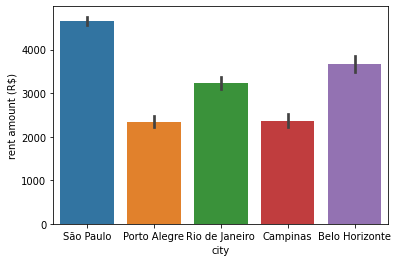

In [ ]:
import seaborn as sns # importing seaborn library to plot our barplot
sns.barplot(x=rent.city,y=rent['rent amount (R$)'])

As we can see from the plot, mean of rent amount is clearly different for each city. So city seems like an important feature for predicting the rent amount. Now we'll confirm this by doing One Way Analysis of Variance of the city column.

**One Way ANOVA :** It compares the means of two or more independent groups in order to determine whether there is a statisticl evidence that the associated means are significantly different or not. It's useful in determing whether a categorical varibale is an important predictor or not. F score(variation between sample means / variation within the samples) of the test needs to be high. Now there's another paramter named as p-value which determines the probability of confidence with which we can reject our null hypothesis which here is that the mean doesn't vary with the groups. If the p-value is 0.05, then with 95% confidence we can reject the null hypothesis implying there is statistically significant variance of means among the various groups.

Here we're looking for a high F score and a p value of less than 0.05.

In [ ]:
from scipy import stats #importing necessary packages to do our one way anova
grouped_city=rent[['city','rent amount (R$)']].groupby(['city'])   #grouping our dataset by city
f_val, p_val=stats.f_oneway(grouped_city.get_group('São Paulo')['rent amount (R$)'],grouped_city.get_group('Porto Alegre')['rent amount (R$)'],grouped_city.get_group('Rio de Janeiro')['rent amount (R$)'],grouped_city.get_group('Campinas')['rent amount (R$)'],grouped_city.get_group('Belo Horizonte')['rent amount (R$)'])
print('F score is: ',f_val)
print('p value is: ',p_val)

F score is:  208.6507059416919
p value is:  1.2182868517894044e-172


As we can see, the F_score is pretty high and the p value is also low. So we can conclude that city is indeed an important feature to predict rent amount. So now we'll move on with converting it's datatype from object to integer.

We conclude that city is an important predictor for the rent amount with a F_score of 208.65 with almost 100% confidence.

Now we'll be converting the city column using one hot encoding as these are not ordinal variables i.e. they don't have any particular order amongst themselves. So if we use Label encoding then our ML model might assign higher weightage to whichever city we have encoded with higher integer values.

In [ ]:
rent_2=pd.get_dummies(rent,drop_first=True) # One Hot Encoding and then dropping the first column to remove multicollinearity.

In [ ]:
rent_2.head() # let's see our new modified dataset

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,70,2,1,1,7,1,1,2065,3300,211,42,5618,0,0,0,1
1,320,4,4,0,20,1,0,1200,4960,1750,63,7973,0,0,0,1
2,80,1,1,1,6,1,0,1000,2800,0,41,3841,0,1,0,0
3,51,2,1,0,2,1,0,270,1112,22,17,1421,0,1,0,0
4,25,1,1,0,1,0,0,0,800,25,11,836,0,0,0,1


Note: If all the city columns are zero in a row then, it belongs to the city Belo Horizonte because we had dropped that row to remove multicollinearity among all the one hot encoded city columns.

In [ ]:
rent=rent_2

As the 4 city columns are still of object type, let's just convert them using astype function.

In [ ]:
rent[['city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo']]=rent[['city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo']].astype('int')

In [ ]:
rent.head() # let's see our new modified dataset with all of the variables as integer type

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_Campinas,city_Porto Alegre,city_Rio de Janeiro,city_São Paulo
0,70,2,1,1,7,1,1,2065,3300,211,42,5618,0,0,0,1
1,320,4,4,0,20,1,0,1200,4960,1750,63,7973,0,0,0,1
2,80,1,1,1,6,1,0,1000,2800,0,41,3841,0,1,0,0
3,51,2,1,0,2,1,0,270,1112,22,17,1421,0,1,0,0
4,25,1,1,0,1,0,0,0,800,25,11,836,0,0,0,1


In [ ]:
rent.dtypes

area                   int64
rooms                  int64
bathroom               int64
parking spaces         int64
floor                  int64
animal                 int64
furniture              int64
hoa (R$)               int64
rent amount (R$)       int64
property tax (R$)      int64
fire insurance (R$)    int64
total (R$)             int64
city_Campinas          int64
city_Porto Alegre      int64
city_Rio de Janeiro    int64
city_São Paulo         int64
dtype: object

# **Data Exploration(2)**

Let's remove some outliers as they'll hamper our model later on.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


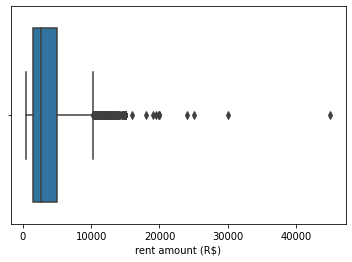

In [ ]:
sns.boxplot(rent['rent amount (R$)']) #create a boxplot to see the distribution of rent amount

As we can see that, most of our data points are concentrated within 20,000.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


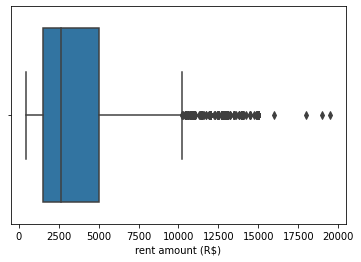

In [ ]:
sns.boxplot(rent[rent['rent amount (R$)']<20000]['rent amount (R$)'])

In [ ]:
rent[rent['rent amount (R$)']<20000].shape # to see how many outliers are there(more than 20,000)

(10683, 16)

**So now we'll remove the 9 outliers which have rent amount more than 20,000.**

In [ ]:
rent=rent[rent['rent amount (R$)']<20000] #removed the outliers

Now we'll plot the heatmap of the correlation of all the columns to see which columns have high correlation with the rent amount columns.

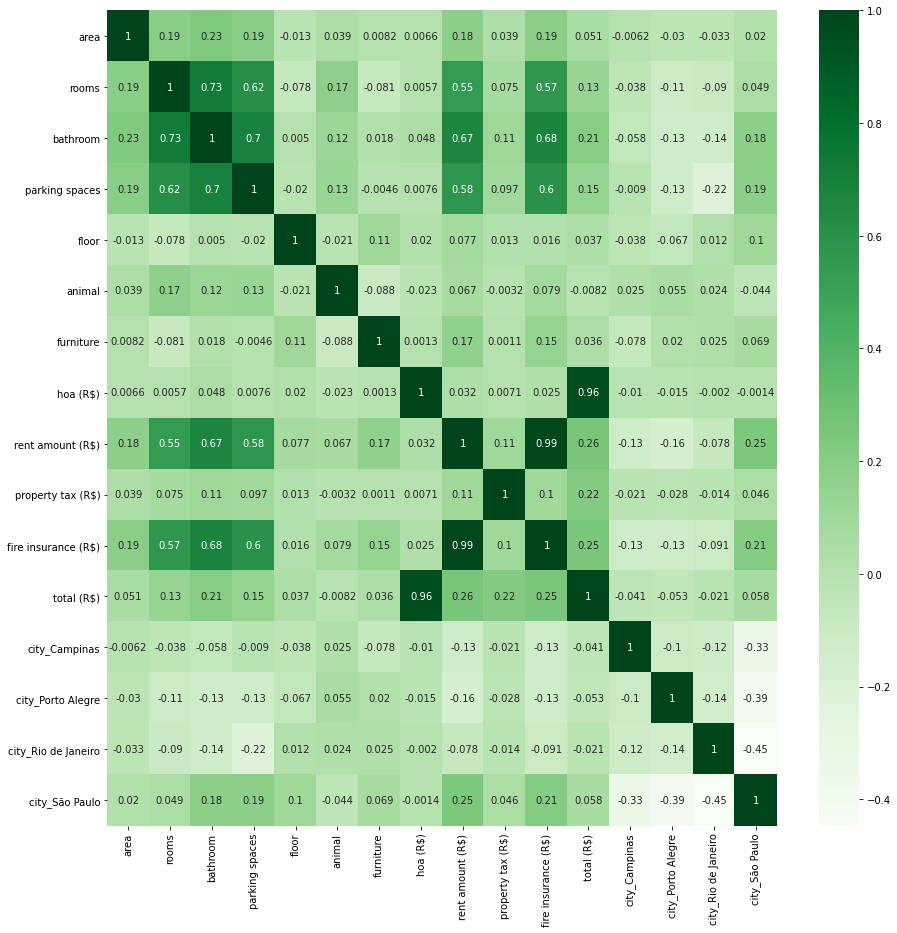

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
sns.heatmap(data=rent.corr(),annot=True,cmap='Greens')

From the heatmap we can only see the correlation but not the p-value of the correlations. So for that we'll import scipy.stats. Also one thing to remember is that correlation is important only when we're finding it for two numerical variables. If one of them is categorical then it doesn't matter.

In [ ]:
import scipy.stats
scipy.stats.pearsonr(rent['rent amount (R$)'],rent['area'])

(0.18088444405035398, 2.968642792556281e-79)

It has a low correlation so it can be dropped but we'll build a model including this as well and then we'll compare the results. As it has a very low p value, it's statistically significant correlation.

In [ ]:
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['rooms']))
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['bathroom']))
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['parking spaces']))

(0.5462355709633167, 0.0)
(0.6733545755685002, 0.0)
(0.5794011061179758, 0.0)


As all of these have high corr values with zero p value(100% confidence level). We will keep these features.

In [ ]:
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['hoa (R$)']))
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['property tax (R$)']))

(0.03173747149391415, 0.0010351930048582922)
(0.10557467808568241, 7.30934490831087e-28)


We can drop hoa and property tax columns because these have statistically significant(low p-value) low correlation values. We can drop hoa column with 99.9% confidence and property tax column with almost 100% confidence.

In [ ]:
print(scipy.stats.pearsonr(rent['rent amount (R$)'],rent['fire insurance (R$)']))

(0.987019905348627, 0.0)


Although it has high correlation with low p value, it should be independent of rent amount. Probably it is some percent of rent amount, so once rent amount is fixed, fire insurance is some percent of it. So we should not use fire insurance to predict the rent amount.

Now we'll be checking if the categorical columns are important predictors or not by first plotting a boxplot and then using one way anova as we did it with floor column.

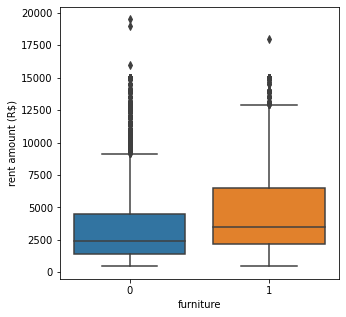

In [ ]:
plt.figure(figsize=(5,5))
z=rent['rent amount (R$)']
sns.boxplot(data=rent,x=rent['furniture'],y=z)

In [ ]:
grouped_furniture=rent[['furniture','rent amount (R$)']].groupby(['furniture'])
f_val, p_val=stats.f_oneway(grouped_furniture.get_group(1)['rent amount (R$)'],grouped_furniture.get_group(0)['rent amount (R$)'])
print('F score is: ',f_val)
print('p value is: ',p_val)

F score is:  311.2654343361237
p value is:  1.0862305662600106e-68


Furniture is an important predictor with 100% confidence as it has a high F_score with almost zero p-value.

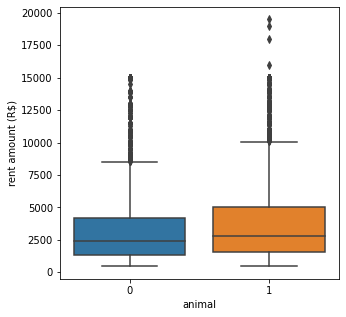

In [ ]:
plt.figure(figsize=(5,5))
z=rent['rent amount (R$)']
sns.boxplot(data=rent,x=rent['animal'],y=z)

In [ ]:
grouped_animal=rent[['animal','rent amount (R$)']].groupby(['animal'])
f_val, p_val=stats.f_oneway(grouped_animal.get_group(1)['rent amount (R$)'],grouped_animal.get_group(0)['rent amount (R$)'])
print('F score is: ',f_val)
print('p value is: ',p_val)

F score is:  48.59541122557756
p value is:  3.33176534250187e-12


Animal should also be kept as it has a high F_score along with almost zero p-value.

Now we'll be plotting a bar plot rent amount vs floors to see if there are any trends.

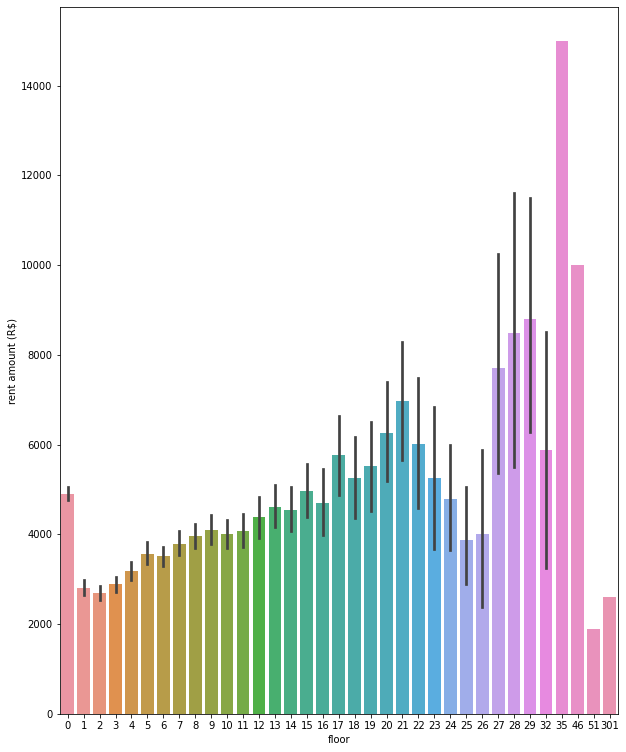

In [ ]:
plt.figure(figsize=(10,13))
sns.barplot(x=rent.floor,y=rent['rent amount (R$)'])

As we can see that, most floors are below 50, we'll remove the outliers i.e. datapoints which are on floors above 50. So we'll be removing only 2 datapoints.

In [ ]:
rent=rent[rent.floor<50] # removing outliers

We'll also bin the floors because they're categorical variables but there are too many of them so binning will help us convert them into certain groups and then we'll do a one way anova test on the bins to see if they've varying mean rent amount or not.

**FLOOR BINNING**

I have binned floor zero as 0, floor 1-10 as 1,floor 11-20 as 2 and 21-50 as 3.

In [ ]:
bins=[-1,0,10,20,50]
group_names = [0,1,2,3]
rent['floor-binned']=pd.cut(rent['floor'],bins,labels=group_names)

In [ ]:
grouped_floor=rent[['floor-binned','rent amount (R$)']].groupby(['floor-binned'])
f_val, p_val=stats.f_oneway(grouped_floor.get_group(0)['rent amount (R$)'],grouped_floor.get_group(1)['rent amount (R$)'],grouped_floor.get_group(2)['rent amount (R$)'],grouped_floor.get_group(3)['rent amount (R$)'])
print('F score is: ',f_val)
print('p value is: ',p_val)

F score is:  209.66947639254272
p value is:  3.7507269687526314e-132


As we can see we've a high F_score with almost zero p-value, we can conclude that our binning was successful.

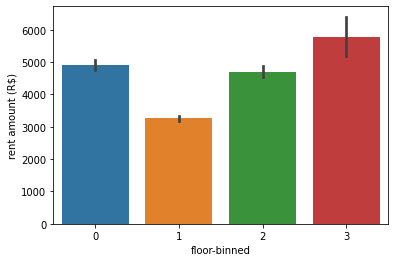

In [ ]:
sns.barplot(x=rent['floor-binned'],y=rent['rent amount (R$)']) # to see mean rent amount of various bins

SO finally we drop the features according to our analysis.

Another thing to note is, if we add hoa, property tax, fire insurance and rent amount column, we get rent total column. So we'll be dropping the rent total column as well as we want to predict the rent amount column.

In [ ]:
features_1=['area','rooms','bathroom','parking spaces','furniture','rent amount (R$)','floor-binned','city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo','animal']
features_2=['rooms','bathroom','parking spaces','furniture','rent amount (R$)','floor-binned','city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo','animal']
rent1=rent[features_1] #dataset with area column considered
rent2=rent[features_2] #dataset wher we dropped the area column

**Rent 1 is our dataset after feature extraction including area column and Rent 2 is the one without the area column. We'll train models using both dataset and check which performs better.**

# **Linear Regression** #

Importing required packages to split our data(into train and test data), build machine learning models, check r2_score and then optimize our models to improve R^2 score.

In [ ]:
from sklearn.linear_model import LinearRegression     #  package to build linear regression model without regularization
from sklearn.model_selection import train_test_split  # package to split our data into training data and test data
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score  #packages to measure accuracy of our ml models
from sklearn.model_selection import GridSearchCV   # package to tune our models
from sklearn.model_selection import cross_val_score  # package to find cross validation score of our models

Let's split our data into predictor set(X) and target variable set(y).

In [ ]:
cols1 = ['area','city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo', 'rooms', 'bathroom', 'parking spaces','animal','furniture','floor-binned']
cols2 = ['city_Campinas','city_Porto Alegre','city_Rio de Janeiro','city_São Paulo', 'rooms', 'bathroom', 'parking spaces','animal','furniture','floor-binned']
X1=rent1[cols1] #predictor set 1
X2=rent2[cols2] #predictor set 2
y1=rent1[['rent amount (R$)']] #target set 1
y2=rent2[['rent amount (R$)']] #target set 2

Now we'll split our data sets into training dat(70% of data) and test data(30% data).

In [ ]:
X1_train,X1_test,y1_train,y1_test=train_test_split(X1,y1,test_size=0.3,random_state=1)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.3,random_state=1)

Now we build our linear regression model.

In [ ]:
Linear_Regression_Model=LinearRegression()  # create linear regression object
Linear_Regression_Model.fit(X1_train,y1_train)  # fit our training data(X1,y1) in the model
prediction=Linear_Regression_Model.predict(X1_test)  # predict on test data using our built model
print(mean_absolute_error(prediction,y1_test))       # printing mean absolute error
print(np.sqrt(mean_squared_error(y1_test, prediction))) #printing mean squared error
print(r2_score(y1_test,prediction))  # printing R2_score of our model

1540.5715170190563
2299.241450664071
0.5369691832125913


Now we'll use cross validation to get more accurate R2_score results for our model.

This is for the data using area column(X1).

In [ ]:
reg=LinearRegression()
k=5   # we'll be splitting our dataset into 5 parts for our cross validation
cv_result=cross_val_score(reg,X1,y1,cv=k)
print('CV Scores: ',cv_result) # to see our r2_scores of each model
print('CV scores average: ',np.sum(cv_result)/k) # to get average r2-scores of the 5 models

CV Scores:  [0.54142372 0.50051718 0.52412951 0.52427177 0.53017911]
CV scores average:  0.5241042567214171


This model below is for dataset without area column(X2)

In [ ]:
reg=LinearRegression()
k=5
cv_result=cross_val_score(reg,X2,y2,cv=k)
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

CV Scores:  [0.54050375 0.53145534 0.52331543 0.52330372 0.5292388 ]
CV scores average:  0.5295634077232383


**Ridge Regression**: Here we'll build our Ridge regression model., one for X1 and another for X2.

In [ ]:
from sklearn.linear_model import Ridge
Lambda=[{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
ridge=Ridge(alpha=1,normalize=True)
ridge_cv=GridSearchCV(ridge,Lambda,cv=5)
ridge_cv.fit(X1,y1)
print("Tuned hyperparameter lambda: {}".format(ridge_cv.best_params_)) 
print("Best score: {}".format(ridge_cv.best_score_))

Tuned hyperparameter lambda: {'alpha': 0.0001}
Best score: 0.5241037606879624


In [ ]:
ridge=Ridge(alpha=1,normalize=True)
ridge_cv=GridSearchCV(ridge,Lambda,cv=5)
ridge_cv.fit(X2,y2)
print("Tuned hyperparameter lambda: {}".format(ridge_cv.best_params_)) 
print("Best score: {}".format(ridge_cv.best_score_))

Tuned hyperparameter lambda: {'alpha': 0.001}
Best score: 0.5295644484922057


**Lasso Regression**: Here we'll build our Lasso regression model.

In [ ]:
from sklearn.linear_model import Lasso
Lambda=[{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
lasso=Lasso(alpha=1,normalize=True)
lasso_cv=GridSearchCV(lasso,Lambda,cv=5)
lasso_cv.fit(X1,y1)
print("Tuned hyperparameter lambda: {}".format(lasso_cv.best_params_)) 
print("Best score: {}".format(lasso_cv.best_score_))

Tuned hyperparameter lambda: {'alpha': 0.1}
Best score: 0.5243935221971755


In [ ]:
Lambda=[{'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
lasso=Lasso(alpha=1,normalize=True)
lasso_cv=GridSearchCV(lasso,Lambda,cv=5)
lasso_cv.fit(X2,y2)
print("Tuned hyperparameter lambda: {}".format(lasso_cv.best_params_)) 
print("Best score: {}".format(lasso_cv.best_score_))

Tuned hyperparameter lambda: {'alpha': 0.0001}
Best score: 0.529563405973173


From all the models above, ridge regression using X2 dataset performed the best with a r2_score of 0.529564

# **KNN Regression**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor #importing package to build our knn regression model
knn=KNeighborsRegressor(n_neighbors=5)            #building model with a random n_neighbours value which we will tune later
knn.fit(X1_train,y1_train)                        #used the X1 dataset
knn.score(X1_test,y1_test)

0.5180344624627857

In [ ]:
Neighbours={'n_neighbors':list(range(1,50))}     #Creating a list of n_neighbours value from which we will choose a value which gives us the highest r2_score from our knn model
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn, Neighbours, cv=5)       # Running grid search to find the optimum value for n_neighbours parameter
knn_cv.fit(X1,y1)                                #fitting our X1 dataset
print("Tuned hyperparameter k: {}".format(knn_cv.best_params_)) 
print("Best score: {}".format(knn_cv.best_score_))

Tuned hyperparameter k: {'n_neighbors': 33}
Best score: 0.5508238500349979


In [ ]:
knn=KNeighborsRegressor(n_neighbors=5)
knn.fit(X2_train,y2_train)
knn.score(X2_test,y2_test)

0.49064782920298305

In [ ]:
Neighbours={'n_neighbors':list(range(1,50))}
knn=KNeighborsRegressor()
knn_cv=GridSearchCV(knn, Neighbours, cv=5)
knn_cv.fit(X2,y2)                             #fitting our X2 dataset
print("Tuned hyperparameter k: {}".format(knn_cv.best_params_)) 
print("Best score: {}".format(knn_cv.best_score_))

Tuned hyperparameter k: {'n_neighbors': 46}
Best score: 0.5419854244417399


As we can see, KNN model using X1 dataset performed the best with a r2_score of 0.55, which is more than any of the linear regression models. So clearly knn model outshined linear regression here.

# **SVR**

In [ ]:
from sklearn.svm import SVR  #importing required package to build our SVR Model
parameters={'gamma':[ 0.01, 0.1, 0.2, 0.5, 0.6],'C':[1,10,100,1000,10000]}  #creating a list of both the parameters required in building svr model
svr=SVR()     #creating SVR object
svr_cv=GridSearchCV(svr,parameters,cv=5)   #running gridsearch to find the optimum value for our paramters by maximizing r2-score
svr_cv.fit(X1,y1.values.ravel())           #fitting our X1 dataset
print(svr_cv.best_params_)                 #printing best parameters
print(svr_cv.best_score_)                  #printing the r2_score by building the best model using the tuned parameters

{'C': 10000, 'gamma': 0.01}
0.5568831043985039


In [ ]:
parameters={'gamma':[ 0.01, 0.1, 0.2, 0.5, 0.6],'C':[1,10,100,1000,10000]}
svr=SVR()
svr_cv=GridSearchCV(svr,parameters,cv=5)
svr_cv.fit(X2,y2.values.ravel())           #fitting our X2 dataset
print(svr_cv.best_params_)
print(svr_cv.best_score_)

{'C': 1000, 'gamma': 0.2}
0.5287793660165667


Here our model trained on X1 data performed better than the one trained on X2 dataset. Also our svr model trained on X1 performed better than the KNN model with a r2_score of 0.5568.

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(max_depth=4,min_samples_split=5,max_leaf_nodes=10)
dtr.fit(X1_train,y1_train)
dtr.score(X1_test,y1_test)

0.5246813856114683

In [ ]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }
dtr_cv = GridSearchCV(dtr, param_grid, cv=5)
dtr_cv.fit(X1,y1)
print("R-Squared:{}".format(dtr_cv.best_score_))
print("Best Hyperparameters::\n{}".format(dtr_cv.best_params_))

R-Squared:0.5834575690883594
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 40, 'min_samples_split': 10}


In [ ]:
dtr=DecisionTreeRegressor(max_depth=4,min_samples_split=5,max_leaf_nodes=10)
dtr.fit(X2_train,y2_train)
dtr.score(X2_test,y2_test)

0.48768417159776795

In [ ]:
dtr_cv = GridSearchCV(dtr, param_grid, cv=5)
dtr_cv.fit(X2,y2)
print("R-Squared:{}".format(dtr_cv.best_score_))
print("Best Hyperparameters::\n{}".format(dtr_cv.best_params_))

R-Squared:0.5314545051799648
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


Clearly the model trained on X1 performed better. Also, the model trained on X1 has the best r2_score till now i.e. 0.583

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor 
rfm=RandomForestRegressor(random_state=1)
rfm.fit(X1_train,y1_train)
rfm_prediction=rfm.predict(X1_test)
print(mean_absolute_error(rfm_prediction,y1_test))
print(np.sqrt(mean_squared_error(y1_test, rfm_prediction)))
print(r2_score(y1_test,rfm_prediction))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


1430.4324425724735
2223.757670952712
0.5668726043772448


Here we will do a randomized search cv first before grid search cv because here there are too many parameters which will cause the gridsearchcv to run for a very long time. So first we do a randomizedsearchcv and then we run the gridsearchcv.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators=[int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4, 8]
bootstrap = [True, False]
random_grid ={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rfm=RandomForestRegressor(random_state=1)
rfm_random_cv=RandomizedSearchCV(estimator=rfm, param_distributions=random_grid, n_iter=50,cv=5)
rfm_random_cv.fit(X1,y1.values.ravel())
print("R-Squared:{}".format(rfm_random_cv.best_score_))
print("Best Hyperparameters:\n{}".format(rfm_random_cv.best_params_))

R-Squared:0.6164172943161615
Best Hyperparameters:
{'n_estimators': 1100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


In [ ]:
n_estimators=[1000,1100,1200]
max_features=['sqrt']
max_depth=[15,20,25]
min_samples_split=[5,10]
min_samples_leaf=[2,4,6]
bootstrap=[True]
random_grid ={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rfm=RandomForestRegressor(random_state=1)
rfm_cv=GridSearchCV(rfm,random_grid,cv=5)
rfm_cv.fit(X1,y1.values.ravel())
print("R-Squared:{}".format(rfm_cv.best_score_))
print("Best Hyperparameters:\n{}".format(rfm_cv.best_params_))

R-Squared:0.6166399027720246
Best Hyperparameters:
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 1200}


In [ ]:
rfm=RandomForestRegressor(random_state=1)
rfm_random_cv=RandomizedSearchCV(estimator=rfm, param_distributions=random_grid, n_iter=50,cv=5)
rfm_random_cv.fit(X2,y2.values.ravel())
print("R-Squared:{}".format(rfm_random_cv.best_score_))
print("Best Hyperparameters:\n{}".format(rfm_random_cv.best_params_))

R-Squared:0.5550006446816087
Best Hyperparameters:
{'n_estimators': 1100, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


In [ ]:
n_estimators=[1100,1200]
max_features=['sqrt']
max_depth=[15,20]
min_samples_split=[10,14]
min_samples_leaf=[6,8,10]
bootstrap=[True]
random_grid ={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rfm=RandomForestRegressor(random_state=1)
rfm_cv=GridSearchCV(rfm,random_grid,cv=5)
rfm_cv.fit(X2,y2.values.ravel())
print("R-Squared:{}".format(rfm_cv.best_score_))
print("Best Hyperparameters:\n{}".format(rfm_cv.best_params_))

R-Squared:0.5550006446816087
Best Hyperparameters:
{'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 1100}


Here the best model is one trained on X1 dataset which had a r2-score of 0.6166 which is the best uptill now. So clearly this is the best model to predict rent amount.

# **Limitations**

**This model is built on houses whose floors are below 50 and rent amount below 20,000. As a result, we've only removed 11 outliers. So this model can only predict rent amount for those houses which are on floor number less than 50 and will  have rent amount in the range of 0-20,000.**

**Also as many of the houses had a invalid floor value of '-', we had to replace them with zero and then built our model, so that must have introduced some inaccuracy in our model.**

# **Conclusion**

**One of the models which used area feature as well performed better than the other model which didn't use the area feature. This was counterintuitive because correlation of rent price and area was very low(0.18).**

**This dataset which contained more datapoints produced more accurate model but the run time of the model was high.**

**The best model was the random forest regressor which after hyperparameter tuning gave a r2_score of 0.616**

In [ ]:
final_model=RandomForestRegressor(random_state=1,bootstrap=True,max_depth=15,max_features='sqrt',min_samples_leaf=4,min_samples_split=10,n_estimators=1200 )
k=5
cv_result=cross_val_score(final_model,X1,y1.values.ravel(),cv=k)
print('CV Scores: ',cv_result)
print('CV scores average: ',np.sum(cv_result)/k)

CV Scores:  [0.63202286 0.6152845  0.61787315 0.61306961 0.60494939]
CV scores average:  0.6166399027720246


In [ ]:
final_model.fit(X1,y1.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)